# Effective PV gradient in the lower layer

In [ ]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import SymmetricalLogLocator, NullFormatter
import cmocean as cmo
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
g = 9.81
f0 = 1e-4
rho1 = 1027.6
rho2 = 1028
gp = g*(rho2-rho1)/rho2
H1 = 1000
H2 = 4000
U = 0.2
mu = 3e-6
alpha_c = f0*U/gp
F1 = f0**2/(gp*H1)
F2 = f0**2/(gp*H2)

In [3]:
def addTicks(ax,base,linthresh):
    ax.xaxis.set_major_locator(SymmetricalLogLocator(base=base, linthresh=linthresh))
    subs = np.arange(2, 10) * 0.1
    ax.xaxis.set_minor_locator(SymmetricalLogLocator(base=base, subs=subs, linthresh=linthresh))
    ax.xaxis.set_minor_formatter(NullFormatter())

    # Filter out ticks inside the linear region
    major_ticks = [t for t in ax.get_xticks() if abs(t) >= linthresh]
    minor_ticks = [t for t in ax.get_xticks(minor=True) if abs(t) >= linthresh]

    major_ticks.extend([-linthresh, linthresh])
    major_ticks = sorted(set(major_ticks))  # remove duplicates and sort

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.tick_params(which="both", bottom=True)

## Assume that the Lagrangian diffusivity represents the PV flux through a flux-gradient relation; derive what the 'effective PV gradient' should be

In [4]:
# diffusivity measures

# Lagrangian: integral of autocorrelation of cross-stream Lagrangian velocity, using the biased autocorrelation
def load_diff_lagr(slope,layer,field,filtertype='highqfilter'):
    file = '../../Results/Results_Diffusivities/SmallLd/lagrangian/acov_diff_s'+slope+'_layer'+layer+'_field'+field+'_1hr12hr_biased_'+filtertype+'.csv'
    return pd.read_csv(file)

def limitDiff_lagr(slope,layer,field,days,run=None,filtertype='highqfilter'):
    if field=='all': # average over all fields
        diff_1 = load_diff_lagr(slope,layer,'1',filtertype=filtertype)
        diff_2 = load_diff_lagr(slope,layer,'2',filtertype=filtertype)
        diff_3 = load_diff_lagr(slope,layer,'3',filtertype=filtertype)
        diff = pd.concat([diff_1,diff_2,diff_3],axis=0)
        diff_end = diff.iloc[:,int(-days*2):] # for each particle run, last X days
    elif run==None: # consider only one field
        diff = load_diff_lagr(slope,layer,field,filtertype=filtertype)
        diff_end = diff.iloc[:,int(-days*2):]
    else: # consider only one field and one particle run
        diff = load_diff_lagr(slope,layer,field,filtertype=filtertype).iloc[run]
        diff_end = diff.iloc[int(-days*2):]
    limdiff = np.nanmean(diff_end.to_numpy()) # average over last X days over all particle runs
    limstd = np.nanstd(diff_end.to_numpy()) # standard deviation over last X days over all particle runs
    return limdiff


def PVflux(slope,layer,field):
    if field=='all': # average over all fields
        fname = '../../Results/Results_Diffusivities/SmallLd/eulerian/simulation_s'+slope+'_field1_layer'+layer+'_flux.csv'
        flux_1 = pd.read_csv(fname)
        fname = '../../Results/Results_Diffusivities/SmallLd/eulerian/simulation_s'+slope+'_field2_layer'+layer+'_flux.csv'
        flux_2 = pd.read_csv(fname)
        fname = '../../Results/Results_Diffusivities/SmallLd/eulerian/simulation_s'+slope+'_field3_layer'+layer+'_flux.csv'
        flux_3 = pd.read_csv(fname)
        flux = pd.concat([flux_1,flux_2,flux_3],axis=0)
    else: # consider only one field
        fname = '../../Results/Results_Diffusivities/SmallLd/eulerian/simulation_s'+slope+'_field'+field+'_layer'+layer+'_flux.csv'
        flux = pd.read_csv(fname)
    limflux = np.nanmean(flux.to_numpy()) # average over all times
    return limflux*-1

In [5]:
def effective_PVgrad(slope):
    diff_Lagr = limitDiff_lagr(slope,layer='2',field='all',days=100,filtertype='highqfilter')
    flux = PVflux(slope,layer='2',field='all')
    return -flux / diff_Lagr

def theoretical_PVgrad(slope):
    return -F2*U + f0*float(slope)/H2

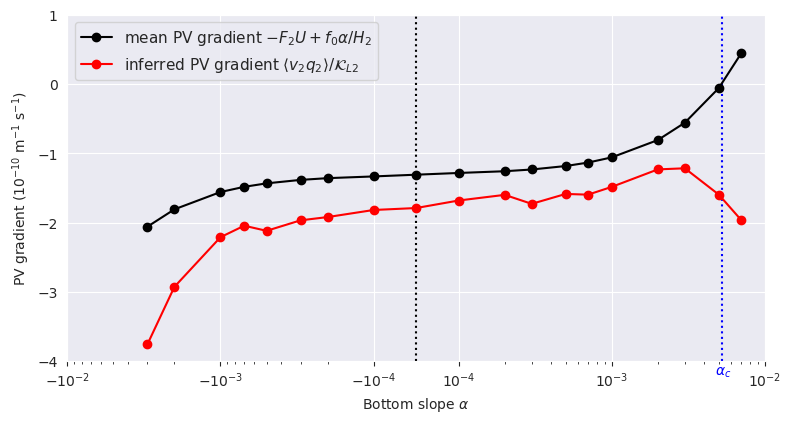

In [ ]:
slopes = ['-3e-3','-2e-3','-1e-3','-7e-4','-5e-4','-3e-4','-2e-4','-1e-4',
          '0','1e-4','2e-4','3e-4','5e-4','7e-4','1e-3','2e-3','3e-3','5e-3','7e-3']
slopes_float = [float(s) for s in slopes]

fig, ax = plt.subplots(1,1,figsize=(9,4.5))

PVgrad_effective = []
PVgrad_theoretical = []
for slope in slopes:
    PVgrad_effective.append(effective_PVgrad(slope)*1e10)
    PVgrad_theoretical.append(theoretical_PVgrad(slope)*1e10)
ax.plot(slopes_float,PVgrad_theoretical,marker='o',label=r'mean PV gradient $-F_2 U + f_0 \alpha/H_2$',color='k',zorder=10)
ax.plot(slopes_float,PVgrad_effective,marker='o',label=r'inferred PV gradient $\langle v_2 q_2 \rangle/\mathcal{K}_{L2}$',color='r',zorder=10)
ax.legend(loc='upper left',fontsize=11)
ax.set_ylabel(r'PV gradient ($10^{-10}$ m$^{-1}$ s$^{-1}$)')
ax.axvline(0,color='k',linestyle=':')
ax.set_xlabel(r'Bottom slope $\alpha$')
ax.set_xscale('symlog', linthresh=1e-4, linscale=0.25)
addTicks(ax,10,1e-4)
ax.set_xlim(-1e-2, 1e-2)
ax.set_ylim(-4,1)
ax.text(alpha_c-5e-4,-4.2,r'$\alpha_c$',color='b')
ax.vlines(alpha_c,ax.get_ylim()[0],ax.get_ylim()[1],color='b',linestyle=':')

#plt.savefig('../../Figures/lower_layer_PVgrad.pdf',bbox_inches='tight')
plt.show()